In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")
sys.path.append("/home/mizworski/Repos/LightGBM/python-package/")
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.utils.validation import column_or_1d
from scipy import interp
from scipy import stats

In [2]:
import lightgbm as lgb

In [3]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)
df.head()

,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,
8595,1958-10-06,technician,married,professional.course,unknown,yes,yes,2008-06-11,telephone,1,999,0,nonexistent,no
40153,1983-07-06,blue-collar,single,high.school,no,yes,no,2010-07-22,cellular,5,999,2,failure,unknown
2715,1979-02-24,blue-collar,married,basic.6y,no,no,yes,2008-05-21,telephone,3,999,0,nonexistent,unknown
33247,1969-06-26,blue-collar,single,high.school,unknown,no,no,2009-05-26,cellular,1,999,0,nonexistent,unknown
1908,1962-04-17,self-employed,married,basic.9y,unknown,yes,no,2008-05-09,telephone,7,999,0,nonexistent,unknown


In [4]:
date_parse_format = '%Y-%m-%d'
def age2class(age):
    if age < 35:
        return 0
    if age < 42:
        return 1
    
    if age < 50:
        return 2
    
    return 3

def preprocess_data(data):
    now = datetime.strptime(data.contact_date.max(), date_parse_format)
    data['sum_nan'] = (data[['default', 'loan', 'education', 'housing', 'job']] == 'unknown').sum(axis=1)
    data['age'] = data.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    data.drop('birth_date', axis=1, inplace=True)
    data['age_range'] = data['age'].apply(age2class)
    data.drop('age', axis=1, inplace=True)
    
    categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y','age', 'sum_nan']))
    X = pd.get_dummies(data, columns=categorical_cols)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    
    X['days_since_contact'] =  X.apply(lambda r: int((now - datetime.strptime(r.contact_date, date_parse_format)).days), 
                                       axis=1)
    
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
    return train_x, train_y, test_x
    

In [7]:

X_train, Y_train, X_test = preprocess_data(df.copy())

from sklearn.model_selection import RandomizedSearchCV
from numpy import random
from sklearn.preprocessing import PolynomialFeatures

In [8]:
X_train['houseXmarried'] = X_train.housing_yes * X_train.marital_married
X_train['uniXmarried'] = X_train['education_university.degree'] * X_train.marital_married
X_train['highschoolXmarried'] = X_train['education_high.school'] * X_train.marital_married
X_train['job_high_paid'] = X_train.job_entrepreneur + X_train.job_management + X_train.job_technician
X_train['campaignXdays_since_contact']= X_train.campaign * X_train.days_since_contact
X_train['campaignXpoutcome_success']= X_train.campaign * X_train.poutcome_success

X_test['houseXmarried'] = X_test.housing_yes * X_test.marital_married
X_test['uniXmarried'] = X_test['education_university.degree'] * X_test.marital_married
X_test['highschoolXmarried'] = X_test['education_high.school'] * X_test.marital_married
X_test['job_high_paid'] = X_test.job_entrepreneur + X_test.job_management + X_test.job_technician
X_test['campaignXdays_since_contact']= X_test.campaign * X_test.days_since_contact
X_test['campaignXpoutcome_success']= X_test.campaign * X_test.poutcome_success

In [9]:
X_train.columns

Index(['campaign', 'pdays', 'sum_nan', 'housing_no', 'housing_unknown',
       'housing_yes', 'age_range_0', 'age_range_1', 'age_range_2',
       'age_range_3', 'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes', 'previous_0',
       'previous_1', 'previous_2', 'previous_3', 'previous_4', 'previous_5',
       'previous_6', 'previous_7', 'contact_cellular

In [10]:
# df.education_1.value_counts()

In [11]:
X_train.head()

,campaign,pdays,sum_nan,housing_no,housing_unknown,housing_yes,age_range_0,age_range_1,age_range_2,age_range_3,...,contact_cellular,contact_telephone,contacted,days_since_contact,houseXmarried,uniXmarried,highschoolXmarried,job_high_paid,campaignXdays_since_contact,campaignXpoutcome_success
id,,,,,,,,,,,,,,,,,,,,,
8595,1,999,1,0,0,1,0,0,0,1,...,0,1,0,902,1,0,0,1,902,0
25853,2,999,0,1,0,0,1,0,0,0,...,1,0,0,741,0,0,0,0,1482,0
19406,3,999,0,0,0,1,0,0,0,1,...,1,0,0,832,1,0,0,0,2496,0
37724,1,999,0,1,0,0,1,0,0,0,...,1,0,0,460,0,0,0,0,460,0
32434,5,999,0,1,0,0,0,0,1,0,...,1,0,0,578,0,0,0,0,2890,0


In [12]:
from mlens.ensemble import Subsemble

[MLENS] backend: threading


In [13]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import  LogisticRegression, LinearRegression
from sklearn.ensemble import VotingClassifier

In [14]:
def get_ensemble():
    model1 = [XGBClassifier(max_depth=4, gamma=3, reg_alpha=0.2137, min_child_weight=2, n_estimators=800,
                      reg_lambda=1, subsample=1, max_delta_step=5, learning_rate=0.01) for i in range(3)]

    model2 = [lgb.LGBMClassifier(
                                    colsample_bytree= 0.9, learning_rate=0.03,
                            boosting_type= 'dart',subsample= 0.75,
                            num_boosting_rounds=256, metric='auc',
                            n_estimators=400, reg_lambda=0, reg_alpha=0, num_leaves=16
                               ) for i in range(3)]
 
    model3 = GradientBoostingClassifier(n_estimators=100)

    eclf = VotingClassifier(estimators=[
        ('xgb0', model1[0]),
        ('lgbm0', model2[0]), ('lgbm1', model2[1])
                                       ], voting='soft')
    return eclf

In [15]:
# ensemble = get_ensemble()

# Train ensemble
# ensemble.fit(X, Y)

In [16]:
# ensemble.predict(X[test])

In [17]:
cv = StratifiedKFold(n_splits=10)

X = X_train.as_matrix()
Y = column_or_1d(Y_train)

i=0 auc=0.7916142026843311
i=1 auc=0.7802215348680189
i=2 auc=0.8096948877270778
i=3 auc=0.7918058102719916
i=4 auc=0.7894586173231508
i=5 auc=0.8280652651940255
i=6 auc=0.765040055109992
i=7 auc=0.7863826312283871
i=8 auc=0.7849866330897181
i=9 auc=0.798562390735762


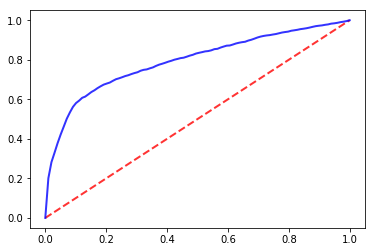

In [18]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0

for train, test in cv.split(X, Y):
    ensemble = get_ensemble()
    
    probas_ = ensemble.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    print('i={} auc={}'.format(i, roc_auc))
    aucs.append(roc_auc)
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
#     plt.show()

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

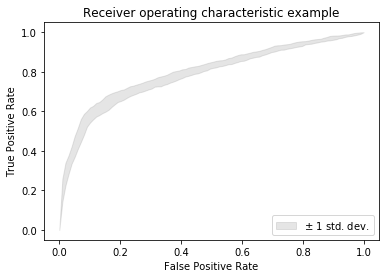

0.79240336477413142

In [ ]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

mean_auc

In [ ]:
ensemble = get_ensemble()
test_probs = ensemble.fit(X, Y).predict_proba(X_test.as_matrix())[:,1]

test_indices = X_test.index.values
results = pd.DataFrame({'id':test_indices, 'y':test_probs})
results_sorted = results.sort_values(['id'])
results_sorted.to_csv('ensemble3.csv', index=False)